# 0. Setup Paths

In [1]:
WORKSPACE_PATH = 'Tensorflow/workspace'
SCRIPTS_PATH = 'Tensorflow/scripts'
APIMODEL_PATH = 'Tensorflow/models'
ANNOTATION_PATH = WORKSPACE_PATH+'/annotations'
IMAGE_PATH = WORKSPACE_PATH+'/images'
MODEL_PATH = WORKSPACE_PATH+'/models'
PRETRAINED_MODEL_PATH = WORKSPACE_PATH+'/pre-trained-models'
CONFIG_PATH = MODEL_PATH+'/my_ssd_mobnet/pipeline.config'
CHECKPOINT_PATH = MODEL_PATH+'/my_ssd_mobnet/'

# 1. Create Label Map

In [2]:
labels = [{'name':'shoe', 'id':1}]

with open(ANNOTATION_PATH + '\label_map.pbtxt', 'w') as f:
    for label in labels:
        f.write('item { \n')
        f.write('\tname:\'{}\'\n'.format(label['name']))
        f.write('\tid:{}\n'.format(label['id']))
        f.write('}\n')

# 2. Create TF records

In [4]:
!python {SCRIPTS_PATH + '/generate_tfrecord.py'} -x {IMAGE_PATH + '/train'} -l {ANNOTATION_PATH + '/label_map.pbtxt'} -o {ANNOTATION_PATH + '/train.record'}
!python {SCRIPTS_PATH + '/generate_tfrecord.py'} -x{IMAGE_PATH + '/test'} -l {ANNOTATION_PATH + '/label_map.pbtxt'} -o {ANNOTATION_PATH + '/test.record'}

Successfully created the TFRecord file: Tensorflow/workspace/annotations/train.record
Successfully created the TFRecord file: Tensorflow/workspace/annotations/test.record


# 3. Download TF Models Pretrained Models from Tensorflow Model Zoo

In [5]:
!cd Tensorflow && git clone https://github.com/tensorflow/models

Cloning into 'models'...
error: unable to create file official/projects/backbone_reuse/configs/experiments/faster_rcnn/fastrcnn_resnet101_nasfpn_cascade_600epochs.yaml: Filename too long
error: unable to create file official/projects/backbone_reuse/configs/experiments/faster_rcnn/fastrcnn_resnet101_nasfpn_cascade_72epochs.yaml: Filename too long
Updating files:  21% (676/3188)
Updating files:  22% (702/3188)
Updating files:  23% (734/3188)
Updating files:  24% (766/3188)
Updating files:  25% (797/3188)
Updating files:  26% (829/3188)
Updating files:  27% (861/3188)
Updating files:  28% (893/3188)
error: unable to create file official/projects/qat/vision/configs/experiments/image_classification/imagenet_mobilenetv2_qat_gpu_batch256.yaml: Filename too long
error: unable to create file official/projects/qat/vision/configs/experiments/image_classification/imagenet_mobilenetv2_qat_gpu_batch512.yaml: Filename too long
error: unable to create file official/projects/qat/vision/configs/experime

In [6]:
#wget.download('http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz')
#!mv ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz {PRETRAINED_MODEL_PATH}
#!cd {PRETRAINED_MODEL_PATH} && tar -zxvf ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz

# 4. Copy Model Config to Training Folder

In [2]:
CUSTOM_MODEL_NAME = 'my_ssd_mobnet' 

In [25]:
!mkdir {'Tensorflow\workspace\models\\'+CUSTOM_MODEL_NAME}
!cp {PRETRAINED_MODEL_PATH+'/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/pipeline.config'} {MODEL_PATH+'/'+CUSTOM_MODEL_NAME}

A subdirectory or file Tensorflow\workspace\models\my_ssd_mobnet already exists.
'cp' is not recognized as an internal or external command,
operable program or batch file.


# 5. Update Config For Transfer Learning

In [3]:
import tensorflow as tf
from object_detection.utils import config_util
from object_detection.protos import pipeline_pb2
from google.protobuf import text_format

In [4]:
CONFIG_PATH = MODEL_PATH+'/'+CUSTOM_MODEL_NAME+'/pipeline.config'

In [ ]:
config = config_util.get_configs_from_pipeline_file(CONFIG_PATH)

In [9]:
config

{'model': ssd {
   num_classes: 1
   image_resizer {
     fixed_shape_resizer {
       height: 320
       width: 320
     }
   }
   feature_extractor {
     type: "ssd_mobilenet_v2_fpn_keras"
     depth_multiplier: 1.0
     min_depth: 16
     conv_hyperparams {
       regularizer {
         l2_regularizer {
           weight: 3.9999998989515007e-05
         }
       }
       initializer {
         random_normal_initializer {
           mean: 0.0
           stddev: 0.009999999776482582
         }
       }
       activation: RELU_6
       batch_norm {
         decay: 0.996999979019165
         scale: true
         epsilon: 0.0010000000474974513
       }
     }
     use_depthwise: true
     override_base_feature_extractor_hyperparams: true
     fpn {
       min_level: 3
       max_level: 7
       additional_layer_depth: 128
     }
   }
   box_coder {
     faster_rcnn_box_coder {
       y_scale: 10.0
       x_scale: 10.0
       height_scale: 5.0
       width_scale: 5.0
     }
   }
   match

In [45]:
pipeline_config = pipeline_pb2.TrainEvalPipelineConfig()
with tf.io.gfile.GFile(CONFIG_PATH, "r") as f:                                                                                                                                                                                                                     
    proto_str = f.read()                                                                                                                                                                                                                                          
    text_format.Merge(proto_str, pipeline_config)  

In [46]:
pipeline_config.model.ssd.num_classes = 1
pipeline_config.train_config.batch_size = 4
pipeline_config.train_config.fine_tune_checkpoint = PRETRAINED_MODEL_PATH+'/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/checkpoint/ckpt-0'
pipeline_config.train_config.fine_tune_checkpoint_type = "detection"
pipeline_config.train_input_reader.label_map_path= ANNOTATION_PATH + '/label_map.pbtxt'
pipeline_config.train_input_reader.tf_record_input_reader.input_path[:] = [ANNOTATION_PATH + '/train.record']
pipeline_config.eval_input_reader[0].label_map_path = ANNOTATION_PATH + '/label_map.pbtxt'
pipeline_config.eval_input_reader[0].tf_record_input_reader.input_path[:] = [ANNOTATION_PATH + '/test.record']

In [47]:
config_text = text_format.MessageToString(pipeline_config)                                                                                                                                                                                                        
with tf.io.gfile.GFile(CONFIG_PATH, "wb") as f:                                                                                                                                                                                                                     
    f.write(config_text)   

# 6. Train the model

In [48]:
print("""python {}/research/object_detection/model_main_tf2.py --model_dir={}/{} --pipeline_config_path={}/{}/pipeline.config --num_train_steps=5000""".format(APIMODEL_PATH, MODEL_PATH,CUSTOM_MODEL_NAME,MODEL_PATH,CUSTOM_MODEL_NAME))

python Tensorflow/models/research/object_detection/model_main_tf2.py --model_dir=Tensorflow/workspace/models/my_ssd_mobnet --pipeline_config_path=Tensorflow/workspace/models/my_ssd_mobnet/pipeline.config --num_train_steps=5000


# 7. Load Train Model From Checkpoint

In [5]:
import os
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder

In [6]:
# Load pipeline config and build a detection model
configs = config_util.get_configs_from_pipeline_file(CONFIG_PATH)
detection_model = model_builder.build(model_config=configs['model'], is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(CHECKPOINT_PATH, 'ckpt-')).expect_partial()

@tf.function
def detect_fn(image):
    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)
    return detections

In [7]:
category_index = label_map_util.create_category_index_from_labelmap(ANNOTATION_PATH+'/label_map.pbtxt')

In [8]:
import tensorflow as tf
from object_detection.utils import config_util
import os
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder
import cv2 as cv
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
from tqdm import tqdm

In [9]:
def inference_as_raw_output(path2images,
                            box_th = 0.25,
                            nms_th = 0.5,
                            to_file = False,
                            data = None,
                            path2dir = False):
    """
    Function that performs inference and return filtered predictions
    
    Args:
      path2images: an array with pathes to images
      box_th: (float) value that defines threshold for model prediction. Consider 0.25 as a value.
      nms_th: (float) value that defines threshold for non-maximum suppression. Consider 0.5 as a value.
      to_file: (boolean). When passed as True => results are saved into a file. Writing format is
      path2image + (x1abs, y1abs, x2abs, y2abs, score, conf) for box in boxes
      data: (str) name of the dataset you passed in (e.g. test/validation)
      path2dir: (str). Should be passed if path2images has only basenames. If full pathes provided => set False.
      
    Returns:
      detections (dict): filtered predictions that model made
    """
    
    for image_path in path2images:
        if path2dir: # if a path to a directory where images are stored was passed in
            image_path = os.path.join(path2dir, image_path.strip())
            
        image_np = load_image_into_numpy_array(image_path)

        input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
        detections = detect_fn(input_tensor)
        
        # checking how many detections we got
        num_detections = int(detections.pop('num_detections'))
        
        # filtering out detection in order to get only the one that are indeed detections
        detections = {key: value[0, :num_detections].numpy() for key, value in detections.items()}
        
        # detection_classes should be ints.
        label_id_offset = 1
        detections['detection_classes'] = detections['detection_classes'].astype(np.int64)+label_id_offset
        
        # defining what we need from the resulting detection dict that we got from model output
        key_of_interest = ['detection_classes', 'detection_boxes', 'detection_scores']
        
        # filtering out detection dict in order to get only boxes, classes and scores
        detections = {key: value for key, value in detections.items() if key in key_of_interest}
        
        if box_th: # filtering detection if a confidence threshold for boxes was given as a parameter
            for key in key_of_interest:
                scores = detections['detection_scores']
                current_array = detections[key]
                filtered_current_array = current_array[scores > box_th]
                detections[key] = filtered_current_array
        
        if nms_th: # filtering rectangles if nms threshold was passed in as a parameter
            # creating a zip object that will contain model output info as
            output_info = list(zip(detections['detection_boxes'],
                                   detections['detection_scores'],
                                   detections['detection_classes']
                                  )
                              )
            boxes, scores, classes = nms(output_info)
            
            detections['detection_boxes'] = boxes # format: [y1, x1, y2, x2]
            detections['detection_scores'] = scores
            detections['detection_classes'] = classes
            
        if to_file and data: # if saving to txt file was requested

            image_h, image_w, _ = image_np.shape
            file_name = f'pred_result_{data}.txt'
            
            line2write = list()
            line2write.append(os.path.basename(image_path))
            
            with open(file_name, 'a+') as text_file:
                # iterating over boxes
                for b, s, c in zip(boxes, scores, classes):
                    
                    y1abs, x1abs = b[0] * image_h, b[1] * image_w
                    y2abs, x2abs = b[2] * image_h, b[3] * image_w
                    
                    list2append = [x1abs, y1abs, x2abs, y2abs, s, c]
                    line2append = ','.join([str(item) for item in list2append])
                    
                    line2write.append(line2append)
                
                line2write = ' '.join(line2write)
                text_file.write(line2write + os.linesep)
        
        return detections

In [10]:
def load_image_into_numpy_array(path):
    """Load an image from file into a numpy array.

    Puts image into numpy array to feed into tensorflow graph.
    Note that by convention we put it into a numpy array with shape
    (height, width, channels), where channels=3 for RGB.

    Args:
      path: the file path to the image

    Returns:
      numpy array with shape (img_height, img_width, 3)
    """
    
    return np.array(Image.open(path))

In [11]:
def nms(rects, thd=0.5):
    """
    Filter rectangles
    rects is array of oblects ([x1,y1,x2,y2], confidence, class)
    thd - intersection threshold (intersection divides min square of rectange)
    """
    out = []

    remove = [False] * len(rects)

    for i in range(0, len(rects) - 1):
        if remove[i]:
            continue
        inter = [0.0] * len(rects)
        for j in range(i, len(rects)):
            if remove[j]:
                continue
            inter[j] = intersection(rects[i][0], rects[j][0]) / min(square(rects[i][0]), square(rects[j][0]))

        max_prob = 0.0
        max_idx = 0
        for k in range(i, len(rects)):
            if inter[k] >= thd:
                if rects[k][1] > max_prob:
                    max_prob = rects[k][1]
                    max_idx = k

        for k in range(i, len(rects)):
            if (inter[k] >= thd) & (k != max_idx):
                remove[k] = True

    for k in range(0, len(rects)):
        if not remove[k]:
            out.append(rects[k])

    boxes = [box[0] for box in out]
    scores = [score[1] for score in out]
    classes = [cls[2] for cls in out]
    return boxes, scores, classes


def intersection(rect1, rect2):
    """
    Calculates square of intersection of two rectangles
    rect: list with coords of top-right and left-boom corners [x1,y1,x2,y2]
    return: square of intersection
    """
    x_overlap = max(0, min(rect1[2], rect2[2]) - max(rect1[0], rect2[0]));
    y_overlap = max(0, min(rect1[3], rect2[3]) - max(rect1[1], rect2[1]));
    overlapArea = x_overlap * y_overlap;
    return overlapArea


def square(rect):
    """
    Calculates square of rectangle
    """
    return abs(rect[2] - rect[0]) * abs(rect[3] - rect[1])

In [12]:
path2images = ['3-1.jpg','4-3.jpg']
inference_as_raw_output(path2images, box_th=0.4, path2dir="test_images", to_file=True, data="test")

{'detection_boxes': [array([0.3460582 , 0.12145847, 0.97111255, 0.8437057 ], dtype=float32)],
 'detection_scores': [0.69003004],
 'detection_classes': [1]}

In [14]:
def inference_with_plot(path2images, box_th=0.25):
    """
    Function that performs inference and plots resulting b-boxes
    
    Args:
      path2images: an array with pathes to images
      box_th: (float) value that defines threshold for model prediction.
      
    Returns:
      None
    """
    for image_path in path2images:

        print('Running inference for {}... '.format(image_path), end='')

        image_np = load_image_into_numpy_array(image_path)
        
        input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
        detections = detect_fn(input_tensor)

        # All outputs are batches tensors.
        # Convert to numpy arrays, and take index [0] to remove the batch dimension.
        # We're only interested in the first num_detections.
        num_detections = int(detections.pop('num_detections'))
        detections = {key: value[0, :num_detections].numpy()
                      for key, value in detections.items()}
        
        detections['num_detections'] = num_detections

        # detection_classes should be ints.
        detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

        label_id_offset = 1
        image_np_with_detections = image_np.copy()

        viz_utils.visualize_boxes_and_labels_on_image_array(
                image_np_with_detections,
                detections['detection_boxes'],
                detections['detection_classes']+label_id_offset,
                detections['detection_scores'],
                category_index,
                use_normalized_coordinates=True,
                max_boxes_to_draw=200,
                min_score_thresh=box_th,
                agnostic_mode=False,
                line_thickness=5)

        plt.figure(figsize=(15,10))
        plt.imshow(image_np_with_detections)
        print('Done')
    plt.show()

In [15]:
import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt

path2images = ['test_images/3-1.jpg', 'test_images/4-3.jpg']
inference_with_plot(path2images, box_th=0.4)

Running inference for test_images/3-1.jpg... Done
Running inference for test_images/4-3.jpg... Done


In [80]:
def inference_with_box(path2images, box_th=0.4):
    res = []
    for image_path in path2images:
        image_np = load_image_into_numpy_array(image_path)
        input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
        detections = detect_fn(input_tensor)

        # All outputs are batches tensors.
        # Convert to numpy arrays, and take index [0] to remove the batch dimension.
        # We're only interested in the first num_detections.
        num_detections = int(detections.pop('num_detections'))
        detections = {key: value[0, :num_detections].numpy()
                      for key, value in detections.items()}
        
        detections['num_detections'] = num_detections

        # detection_classes should be ints.
        detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

        boxes = []
        for i in range(len(detections['detection_boxes'])):
            if detections['detection_scores'][i] > box_th:
                boxes.append(detections['detection_boxes'][i])
        res.append(boxes)
    return res

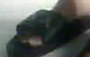

In [136]:
path2images = ['test_images/1-1.jpg']
tmp = inference_with_box(path2images, box_th=0.4)
image_np = load_image_into_numpy_array('test_images/1-1.jpg')

a, b, c, d = tmp[0][1]
xmin = int(np.round(b * 320))
xmax = int(np.round(d * 320))
ymin = int(np.round(a * 240))
ymax = int(np.round(c * 240))
xmin, ymin, xmax, ymax   # xmin,ymin is the top left corner; xmax,ymax is the bottom right corner

import numpy as np
from tensorflow.keras.preprocessing.image import array_to_img
test=array_to_img(image_np[ymin:ymax+1, xmin:xmax+1])

test